In [1]:
import random
import numpy as np
import torch as th
from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
from utils.plots import multiviz_trajs

from models.vqvae import VQVAEAgents
from models.sampler.pixelcnn import PixelCNN
from utils.bernstein_coeff_order10_arbitinterval import get_coeffs
from utils.load_data import get_real_dataset_num_agents, get_varying_bound_dataset_num_agent

In [18]:
num         = 50
t_fin       = 5
num_agent   = 4

vq_name     = "vary_01"
px_name     = "vary_01"
batch_size  = 64

nef         = 128   # Size of feature maps in encoder
ndf         = 128   # Size of feature maps in decoder

zdim        = 3     # Size of codebook vectors in the quantizer layer
znum        = 512    # number of codebook vectors

lheight     = 5     # latent vector height
lwidth      = 5     # Latent vector width

num_epochs  = 500
device      = th.device("cuda" if th.cuda.is_available() else "cpu")

print(device)
# th.set_float32_matmul_precision('high')

cuda


In [3]:
# SEED = 13
# th.manual_seed(SEED)
# th.cuda.manual_seed(SEED)

In [4]:
P, Pdot, Pddot = get_coeffs(num, t_fin, device)
nvar = P.size(dim=-1) 

In [5]:
dataset = get_varying_bound_dataset_num_agent(P.cpu(), num_agent, nvar)
len_data = len(dataset)
len_val = max(1, int(0.1 * len_data))

gen = th.Generator().manual_seed(42)
train_set, val_set = random_split(dataset, [len_data - len_val, len_val], gen)

val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=False)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=False)

print(len_data)

19999


In [6]:
vq_model = VQVAEAgents(
    P, Pdot, Pddot, num_agent=num_agent, nvar=11, emb_num=znum, emb_dim=zdim, zdim=zdim, tdim=3, beta=0.25,
    lheight=lheight, lwidth=lwidth, nef=nef, ndf=ndf, device=device, batch=batch_size
)
vq_model.load_state_dict(th.load(f"./resources/weights/vqvae/{vq_name}_agents_{num_agent}", weights_only=False))
cvq_model = th.compile(vq_model)

vq_model.eval()

for param in vq_model.parameters():
    param.requires_grad = False

In [7]:
sampler = PixelCNN(num_agent, lheight, lwidth, nf=16, n_channels=32, n_layers=3, emb_num=znum, cond_input_shape=96, cond_output_shape=(lheight, lwidth))
sampler.train()

summary(sampler, [(64, num_agent, lheight, lwidth), (64, num_agent, 3, 2)])

Layer (type:depth-idx)                             Output Shape              Param #
PixelCNN                                           [64, 512, 5, 5]           --
├─LabelNet: 1-1                                    [64, 4, 5, 5]             --
│    └─Sequential: 2-1                             [64, 4, 5, 5]             --
│    │    └─ConvTranspose2d: 3-1                   [64, 128, 4, 4]           3,072
│    │    └─BatchNorm2d: 3-2                       [64, 128, 4, 4]           256
│    │    └─LeakyReLU: 3-3                         [64, 128, 4, 4]           --
│    │    └─Dropout2d: 3-4                         [64, 128, 4, 4]           --
│    │    └─ConvTranspose2d: 3-5                   [64, 64, 8, 8]            204,800
│    │    └─BatchNorm2d: 3-6                       [64, 64, 8, 8]            128
│    │    └─LeakyReLU: 3-7                         [64, 64, 8, 8]            --
│    │    └─Dropout2d: 3-8                         [64, 64, 8, 8]            --
│    │    └─ConvTranspose

In [ ]:
sampler_optimizer = th.optim.AdamW(sampler.parameters(), lr=1e-3, weight_decay=5e-2)
sampler_scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(sampler_optimizer, factor=0.5, patience=3)

In [9]:
train_loss, val_losses = [], []
val_accuracies = []

progression_bar = tqdm(range(num_epochs))
for epoch in progression_bar:
	progression_bar.set_description(f"Epoch: {epoch:>2}/{num_epochs:>2}")

	sampler.train()
	ep_losses = []
	for (x_trajs, y_trajs, z_trajs), _ in tqdm(train_loader):

		x_trajs, y_trajs, z_trajs = (
			x_trajs.to(device=device), y_trajs.to(device=device), z_trajs.to(device=device)
		)
		trajs = th.stack([x_trajs, y_trajs, z_trajs], dim=-3)
		conditions = th.stack([trajs[..., 0], trajs[..., -1]], dim=-1)

		_, quantized_indices, *_ = vq_model.encode(trajs)
		# probs = sampler(quantized_indices.unsqueeze(dim=1).float(), conditions.flatten(start_dim=1).unsqueeze(dim=1))
		probs = sampler(quantized_indices.unsqueeze(dim=1).float().repeat_interleave(num_agent, dim=1), conditions.permute(0, 2, 1, 3))
		
		loss = th.nn.functional.nll_loss(th.nn.functional.log_softmax(probs, dim=1), quantized_indices)
		# loss = th.nn.functional.cross_entropy(probs, quantized_indices)

		sampler_optimizer.zero_grad()
		loss.backward()
		sampler_optimizer.step()
		
		ep_losses.append(loss.item())

	with th.no_grad():
		sampler.eval()
		ep_val_acc, ep_val_loss = [], []
		for (x_trajs, y_trajs, z_trajs), _ in val_loader:
			x_trajs, y_trajs, z_trajs = (
				x_trajs.to(device=device), y_trajs.to(device=device), z_trajs.to(device=device)
			)
			trajs = th.stack([x_trajs, y_trajs, z_trajs], dim=-3)
			conditions = th.stack([trajs[..., 0], trajs[..., -1]], dim=-1)

			_, true_indices, *_ = vq_model.encode(trajs)
			probs = []
			samples = th.zeros(conditions.shape[0], num_agent, lheight, lwidth, dtype=th.float32, device=device)

			for i in range(lheight):
				for j in range(lwidth):
					# output = sampler(samples, conditions.flatten(start_dim=1).unsqueeze(dim=1))
					output = sampler(samples, conditions.permute(0, 2, 1, 3))
					probs.append(output[:, :, i, j])
					samples[:, :, i, j] = th.multinomial(
						th.nn.functional.softmax(output[:, :, i, j].cpu(), dim=-1),
						num_samples=1
					)

			probs = th.stack(probs, dim=-1)
			probs = probs.reshape(*probs.shape[:-1], lheight, lwidth)
			val_loss = th.nn.functional.nll_loss(th.nn.functional.log_softmax(probs, dim=1), true_indices)
			# val_loss = th.nn.functional.cross_entropy(probs, true_indices)
			
			pred_indices = probs.topk(k=1, dim=1)[1].squeeze(dim=-1)
			val_accuracy = (pred_indices.squeeze(dim=1) == true_indices).sum() / true_indices.numel()
			ep_val_acc.append(val_accuracy.item())
			ep_val_loss.append(val_loss.item())

	ep_loss = np.average(ep_losses)
	ep_accuracy = np.average(ep_val_acc)
	ep_loss_test = np.average(ep_val_loss)

	progression_bar.set_postfix({
		'loss_train': f'{ep_loss:.4f}', 
		'loss_val': f'{ep_loss_test:.4f}', 
		'accuracies': f'{ep_accuracy:.4f}', 
	})

	train_loss.append(ep_loss)
	val_losses.append(ep_loss_test)
	val_accuracies.append(ep_accuracy)
	sampler_scheduler.step(ep_loss)

Epoch:  0/500:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 309/500:  62%|██████▏   | 309/500 [29:31<18:14,  5.73s/it, loss_train=2.3866, loss_val=2.3143, accuracies=0.3330]


KeyboardInterrupt: 

In [19]:
# Epoch: 309/500:  62%|██████▏   | 309/500 [29:31<18:14,  5.73s/it, loss_train=2.3866, loss_val=2.3143, accuracies=0.3330]
th.save(sampler.state_dict(), f"./resources/weights/sampler/pixel/px_{px_name}_vq_{vq_name}_agents_{num_agent}")

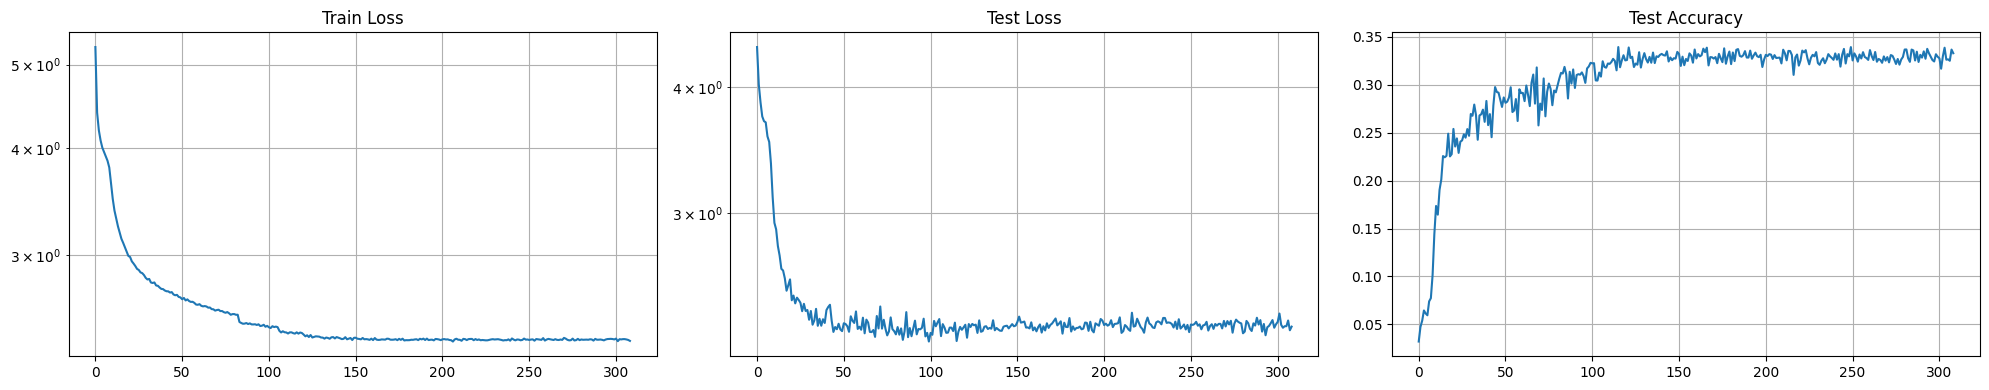

In [11]:
fig = plt.figure(figsize=(20, 4))
ax = plt.subplot(131)
ax.plot(train_loss)
ax.set_title("Train Loss")
ax.set_yscale('log')
ax.grid(which="both")

ax = plt.subplot(132)
ax.plot(val_losses)
ax.set_title("Test Loss")
ax.set_yscale('log')
ax.grid(which="both")

ax = plt.subplot(133)
ax .plot(val_accuracies)
ax.set_title("Test Accuracy")
ax.grid(which="both")

plt.tight_layout()
plt.show()

In [ ]:
sample_b = 10
vq_model = VQVAEAgents(
    P, Pdot, Pddot, num_agent=num_agent, nvar=11, emb_num=znum, emb_dim=zdim, zdim=zdim, tdim=3, beta=0.3,
    lheight=lheight, lwidth=lwidth, nef=nef, ndf=ndf, device=device, batch=sample_b
)
sampler.eval()
vq_model.eval()
vq_model.load_state_dict(th.load(f"./resources/weights/vqvae/{vq_name}_agents_{num_agent}", weights_only=False))

In [43]:
val_loader = DataLoader(val_set, batch_size=1, shuffle=True, drop_last=False)
(x_trajs, y_trajs, z_trajs), _ = next(iter(val_loader))

with th.no_grad():
	trajs = th.stack([x_trajs, y_trajs, z_trajs], dim=-3).to(device)
	x_init, y_init, z_init = trajs[:, 0, :, 0], trajs[:, 1, :, 0], trajs[:, 2, :, 0]
	x_fin, y_fin, z_fin = trajs[:, 0, :, -1], trajs[:, 1, :, -1], trajs[:, 2, :, -1]

	rec_sol, quantizer_loss = vq_model(
		trajs, 
		x_init.repeat_interleave(sample_b, 0), y_init.repeat_interleave(sample_b, 0), z_init.repeat_interleave(sample_b, 0), 
		x_fin.repeat_interleave(sample_b, 0), y_fin.repeat_interleave(sample_b, 0), z_fin.repeat_interleave(sample_b, 0)
	)
	rec_trajs = rec_sol @ P.mT
	rec_trajs = rec_trajs.cpu().numpy()
	rx_trajs, ry_trajs, rz_trajs = rec_trajs[:, 0, :, :], rec_trajs[:, 1, :, :], rec_trajs[:, 2, :, :]
	
	conditions = th.stack([trajs[..., 0], trajs[..., -1]], dim=-1)

	latent_idx = th.zeros(sample_b, num_agent, lheight, lwidth, dtype=th.float32, device=device)
	for i in range(lheight):
		for j in range(lwidth):
			# output = sampler(latent_idx, conditions.flatten(start_dim=1).unsqueeze(dim=1))
			output = sampler(latent_idx, conditions.permute(0, 2, 1, 3))
			latent_idx[:, :, i, j] = th.multinomial(
				th.nn.functional.softmax(output[:, :, i, j].cpu(), dim=-1),
				num_samples=1
			)

	latent = vq_model.quantizer.embedding(latent_idx.to(dtype=th.int32))[:, 0]
	
	rec_sol = vq_model.decode(
		latent, 
		x_init.repeat_interleave(sample_b, 0), y_init.repeat_interleave(sample_b, 0), z_init.repeat_interleave(sample_b, 0), 
		x_fin.repeat_interleave(sample_b, 0), y_fin.repeat_interleave(sample_b, 0), z_fin.repeat_interleave(sample_b, 0)
	)
	rec_trajs = rec_sol @ P.mT
	rec_trajs = rec_trajs.cpu().numpy()
	px_trajs, py_trajs, pz_trajs = rec_trajs[:, 0, :, :], rec_trajs[:, 1, :, :], rec_trajs[:, 2, :, :]

In [44]:
# Ground truth
multiviz_trajs(x_trajs, y_trajs, z_trajs, nrows=1, ncols=1, num_agents=num_agent, height=400, width=1_600)

In [45]:
# Reconstructed 
multiviz_trajs(rx_trajs[:3], ry_trajs[:3], rz_trajs[:3], nrows=1, ncols=3, num_agents=num_agent, height=400, width=1_600)

In [46]:
# Generated
multiviz_trajs(px_trajs[:3], py_trajs[:3], pz_trajs[:3], nrows=1, ncols=3, num_agents=num_agent, height=400, width=1_600)

In [47]:
collect_data = True
centers, radiis = [], []
primal_sol, expert_data, cond_data, latent = [], [], [], []

if collect_data:
    val_loader = DataLoader(dataset, batch_size=1, shuffle=True, drop_last=False)

    for (x_trajs, y_trajs, z_trajs), (center, radii) in tqdm(val_loader):

        with th.no_grad():
            trajs = th.stack([x_trajs, y_trajs, z_trajs], dim=-3).to(device)
            x_init, y_init, z_init = trajs[:, 0, :, 0], trajs[:, 1, :, 0], trajs[:, 2, :, 0]
            x_fin, y_fin, z_fin = trajs[:, 0, :, -1], trajs[:, 1, :, -1], trajs[:, 2, :, -1]
            
            state = th.cat([
                trajs[..., :1], th.zeros(1, 3, num_agent, 2, device=device), 
                trajs[..., -1:], th.zeros(1, 3, num_agent, 2, device=device)
            ], dim=-1) 
            conditions = th.stack([trajs[..., 0], trajs[..., -1]], dim=-1)

            latent_idx = th.zeros(sample_b, num_agent, lheight, lwidth, dtype=th.float32, device=device)
            for i in range(lheight):
                for j in range(lwidth):
                    output = sampler(latent_idx, conditions.permute(0, 2, 1, 3))
                    latent_idx[:, :, i, j] = th.multinomial(
                        th.nn.functional.softmax(output[:, :, i, j].cpu(), dim=-1),
                        num_samples=1
                    )

            latent = vq_model.quantizer.embedding(latent_idx.to(dtype=th.int32))[:, 0]
            
            rec_sol = vq_model.decode(
                latent, 
                x_init.repeat_interleave(sample_b, 0), y_init.repeat_interleave(sample_b, 0), z_init.repeat_interleave(sample_b, 0), 
                x_fin.repeat_interleave(sample_b, 0), y_fin.repeat_interleave(sample_b, 0), z_fin.repeat_interleave(sample_b, 0)
            )
            rec_trajs = rec_sol @ P.mT
            rec_trajs = rec_trajs.cpu().numpy()
            px_trajs, py_trajs, pz_trajs = rec_trajs[:, 0, :, :], rec_trajs[:, 1, :, :], rec_trajs[:, 2, :, :]

        primal_sol.append(rec_sol.detach().cpu())
        expert_data.append(trajs.detach().cpu())
        cond_data.append(state.repeat_interleave(sample_b, 0).detach().cpu())
        centers.append(center.repeat_interleave(sample_b, 0).detach().cpu())
        radiis.append(radii.repeat_interleave(sample_b, 0).detach().cpu())

    np.savez(
        f"./resources/data/traj_data/varying_bounds_{num_agent}/multi_trajs_vq_{vq_name}_batch_{sample_b}", 
        primals=th.cat(primal_sol).detach().cpu().numpy(),
        experts=th.cat(expert_data).detach().cpu().numpy(),
        condition=th.cat(cond_data).detach().cpu().numpy(),
        centers=th.cat(centers).detach().cpu().numpy(),
        radiis=th.cat(radiis).detach().cpu().numpy(),
    )

100%|██████████| 19999/19999 [16:48<00:00, 19.83it/s]
